ImageBind is a model developed by Meta AI that creates a joint embedding space for multiple modalities, including images. By extracting embeddings from images, we can perform clustering to group similar images together.

In this tutorial, we'll:

1. Install dependencies
2. Import libraries
3. Load and preprocess images
4. Extract image embeddings using ImageBind
5. Cluster the embeddings
6. Visualize the clusters

1. Install Dependencies
First, we need to install PyTorch and clone the ImageBind repository.

In [1]:
# Install PyTorch (make sure the CUDA version matches your runtime)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

# Clone the ImageBind repository
!git clone https://github.com/facebookresearch/ImageBind.git

# Install ImageBind dependencies
!pip install -r ImageBind/requirements.txt

# Install additional libraries
!pip install faiss-gpu scikit-learn matplotlib


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (68/68), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-t3usv5g4/pytorchvideo_ad2720903e3f48a69f1983ea37002f0b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-t3usv5g4/pytorchvideo_ad2720903e3f48a69f1983ea37002f0b
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94

2. Import Libraries


In [2]:
import sys
sys.path.append('ImageBind')  # Add ImageBind to the Python path

import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


3. Load and Preprocess Images

We'll use a set of sample images.

In [4]:
!pip install requests

In [5]:
import os
import requests

# Create a directory to store images
os.makedirs('images', exist_ok=True)

# List of image URLs and their corresponding filenames
image_urls = [
    ('https://images.pexels.com/photos/4587995/pexels-photo-4587995.jpeg', 'images/dog.jpg'),
    ('https://images.pexels.com/photos/320014/pexels-photo-320014.jpeg', 'images/cat.jpg'),
    ('https://images.pexels.com/photos/712876/pexels-photo-712876.jpeg', 'images/flower.jpg'),
    ('https://images.pexels.com/photos/552789/pexels-photo-552789.jpeg', 'images/mountain.jpg'),
    ('https://images.pexels.com/photos/261102/pexels-photo-261102.jpeg', 'images/beach.jpg'),
]

# Headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0',
}

# Download each image
for url, filename in image_urls:
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f'Downloaded {filename}')
    else:
        print(f'Failed to download {filename}. Status code: {response.status_code}')


Downloaded images/dog.jpg
Downloaded images/cat.jpg
Downloaded images/flower.jpg
Downloaded images/mountain.jpg
Downloaded images/beach.jpg


3. Load and Preprocess Images

In [6]:
from torchvision import transforms
from PIL import Image

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711],
    ),
])

# Load images
import glob
image_paths = glob.glob('images/*.jpg')
images = []
for path in image_paths:
    image = Image.open(path).convert('RGB')
    images.append(transform(image))


4. Extract Image Embeddings Using ImageBind

Load the pre-trained ImageBind model.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)


Using device: cpu


  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

Prepare inputs and extract embeddings.


In [9]:
image_tensor = torch.stack(images)

with torch.no_grad():
    inputs = {
        ModalityType.VISION: image_tensor.to(device),
    }
    embeddings = model(inputs)

Get the image embeddings

In [10]:
image_embeddings = embeddings[ModalityType.VISION]
print(f'Embeddings shape: {image_embeddings.shape}')

Embeddings shape: torch.Size([5, 1024])


5. Cluster the Embeddings

We'll use KMeans clustering to cluster the image embeddings.

In [15]:
from sklearn.cluster import KMeans

# Convert embeddings to numpy array
embeddings_np = image_embeddings.cpu().numpy()

# Reduce dimensionality with PCA for better clustering performance
pca = PCA(n_components=5)
embeddings_pca = pca.fit_transform(embeddings_np)

# Choose the number of clusters
num_clusters = 2  # Adjust based on your dataset

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings_pca)
labels = kmeans.labels_


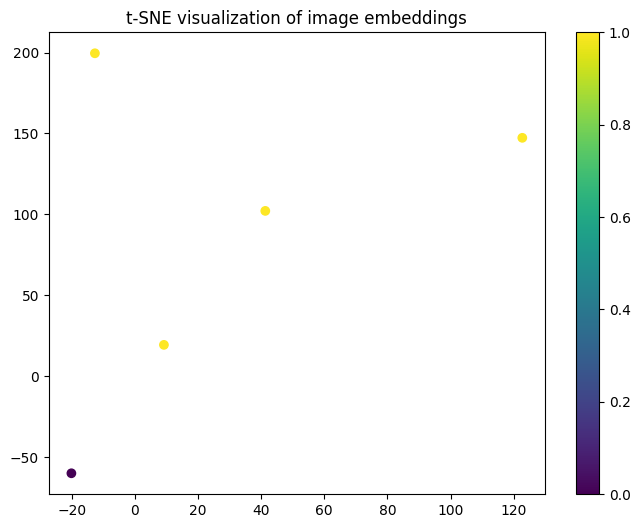

In [19]:
from sklearn.manifold import TSNE

# Reduce dimensionality with t-SNE
perplexity_value = 2  # Set perplexity to less than n_samples
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of image embeddings')
plt.colorbar()
plt.show()


In [13]:
def plot_image_clusters(image_paths, labels):
    clusters = {}
    for idx, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(image_paths[idx])

    for label, paths in clusters.items():
        print(f"\nCluster {label}:")
        fig, axes = plt.subplots(1, len(paths), figsize=(15, 5))
        for ax, path in zip(axes, paths):
            image = Image.open(path)
            ax.imshow(image)
            ax.axis('off')
        plt.show()


['images/mountain.jpg', 'images/dog.jpg', 'images/cat.jpg', 'images/beach.jpg', 'images/flower.jpg']


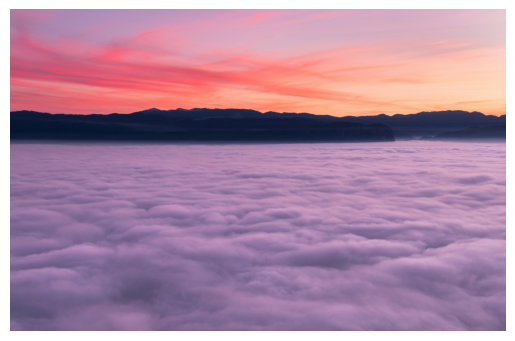

In [21]:
%matplotlib inline

print(image_paths)

image = Image.open(image_paths[0])
plt.imshow(image)
plt.axis('off')
plt.show()


Cluster 1:


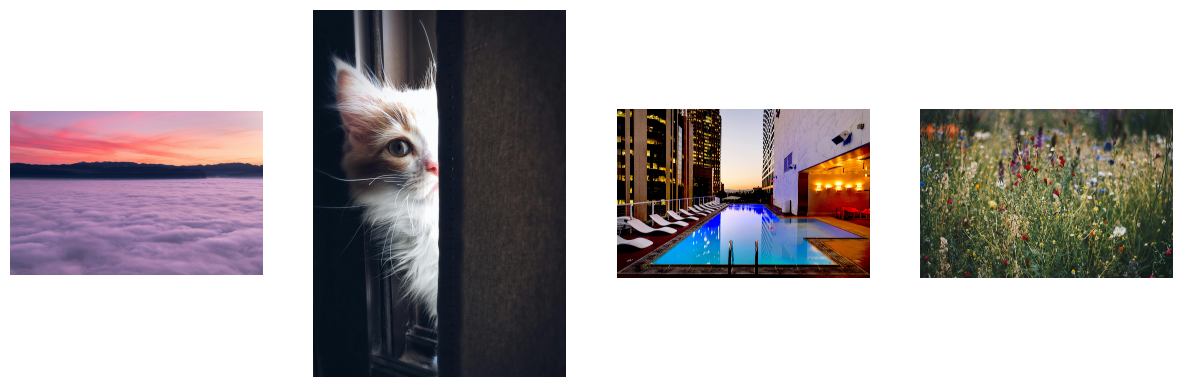


Cluster 0:


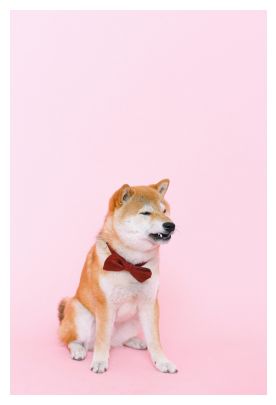

In [22]:
def plot_image_clusters(image_paths, labels):
    clusters = {}
    for idx, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(image_paths[idx])

    for label, paths in clusters.items():
        print(f"\nCluster {label}:")
        num_images = len(paths)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        # Ensure axes is iterable
        if num_images == 1:
            axes = [axes]

        for ax, path in zip(axes, paths):
            image = Image.open(path)
            ax.imshow(image)
            ax.axis('off')
        plt.show()

# Call the function to display the clusters
plot_image_clusters(image_paths, labels)